# Ensemble: Bagging x Boosting x Stacking

Ensemble nada mais é do que a sabedoria da maioria. Aqui combinamos vários modelos mais simples em um único modelo robusto a fim de reduzir o viés, variância e/ou aumentar a acurácia.
<br>


## Tipos de Ensemble:
- __1. Bagging (short for bootstrap aggregation)__: Treina paralelamente N modelos mais fracos (geralmente do mesmo tipo - homogênio) com N subsets distintos criados com amostragem randômica e reposição. Cada modelo é avaliado na fase de teste com o label definido pela moda (classificação) ou pela média dos valores (regressão). Os métodos de Bagging reduzem a variância da predição. <br>
Algoritimos  famosos: Random Forest <br>
<img src='images/bagging.png' style="width:600px"  text="http://cheatsheets.aqeel-anwar.com" />  
<br>
<br>
- __2. Boosting__: Treina N modelos mais fracos (geralmente do mesmo tipo - homogênio) de forma sequencial. Os pontos que foram classificados erroneamente recebem um peso maior para entrar no próximo modelo. Na fase de teste, cada modelo é avaliado com base do erro de teste de cada modelo, a predição é feita com um peso sobre a votação. Os métodos de Boosting reduzem o viés da predição. <br>
Algoritimos  famosos: AdaBoost, Gradient Boosting, XGBoost, CatBoost, LightGBM (Light Gradient Boosting Machine) <br>
<img src='images/boosting.png' style="width:600px" text="Fonte: http://cheatsheets.aqeel-anwar.com" />
<br>
<br>
- __3. Stacking__: Treina N modelos mais fracos (geralmente de tipos distintos - heterogênio) em um subset do conjunto de dados. Uma vez que os modelos foram treinados, cria-se um novo modelo (meta learning) para combinar a saída de cada um dos modelos mais fracos resultando na predição final. Isso é feito no segundo subset dos dados. Na fase de teste, cada modelo mais fraco faz sua predição independentemente e esses labels entram como features do meta learner para gerar a predição final.
<br>
<img src='images/stacking.png' style="width:600px" text="Fonte: http://cheatsheets.aqeel-anwar.com" />
<br>
<br>

##### Resumo:
<img src='images/comparison_img.png' style="width:600px" text="Fonte: https://quantdare.com/what-is-the-difference-between-bagging-and-boosting" />

<img src='images/comparison.png' style="width:600px" />


# Boosting : AdaBoost

O AdaBoost significa **Adaptive Boosting**, e tem como procedimento geral **a criação sucessiva dos chamados weak learners**, que são modelos bem fracos de aprendizagem - geralmente, **árvores de um único nó (stumps)**.

<img src="https://miro.medium.com/max/1744/1*nJ5VrsiS1yaOR77d4h8gyw.png" width=300>

O AdaBoost utiliza os **erros da árvore anterior para melhorar a próxima árvore**. As predições finais são feitas com base **nos pesos de cada stump**, cuja determinação faz parte do algoritmo!

<img src="https://static.packt-cdn.com/products/9781788295758/graphics/image_04_046-1.png" width=700>

Vamos entender um pouco melhor...

Aqui, o bootstrapping não é utilizado: o método começa treinando um classificador fraco **no dataset original**, e depois treina diversas cópias adicionais do classificador **no mesmo dataset**, mas dando **um peso maior às observações que foram classificadas erroneamente** (ou, no caso de regressões, a observações **com o maior erro**).

Assim, após diversas iterações, classificadores/regressores vão sequencialmente "focando nos casos mais difíceis", e construindo um classificador encadeado que seja forte, apesar de utilizar diversos classificadores fracos em como elementos fundamentais.

<img src="https://www.researchgate.net/profile/Zhuo_Wang8/publication/288699540/figure/fig9/AS:668373486686246@1536364065786/Illustration-of-AdaBoost-algorithm-for-creating-a-strong-classifier-based-on-multiple.png" width=500>

De forma resumida, as principais ideias por trás deste algoritmo são:

- O algoritmo cria e combina um conjunto de **modelos fracos** (em geral, stumps);
- Cada stump é criado **levando em consideração os erros do stump anterior**;
- Alguns dos stumps têm **maior peso de decisão** do que outros na predição final;

As classes no sklearn são:

- [AdaBoostClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html)

- [AdaBoostRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostRegressor.html#sklearn.ensemble.AdaBoostRegressor)

Note que não há muitos hiperparâmetros. O mais importante, que deve ser tunado com o grid/random search, é:

- `n_estimators` : o número de weak learners encadeados;

Além disso, pode também ser interessante tunar os hiperparâmetros dos weak learners. Isso é possível de ser feito, como veremos a seguir!


In [14]:
from sklearn.compose import ColumnTransformer

from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder

from sklearn.impute import SimpleImputer

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split

from sklearn.pipeline import Pipeline
from google.colab import drive
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

In [15]:
# criar uma função de preprocessamento
def pipe_pre_process_german():

    df = pd.read_csv("/content/german_credit_data.csv")

    X = df.drop(columns="Risk")
    y = df["Risk"]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

    # ==========================================================

    pipe_features_num = Pipeline([("input_num", SimpleImputer(strategy="mean")),
                                  ("std", StandardScaler())])

    features_num = X_train.select_dtypes(include=np.number).columns.tolist()

    # ==========================================================

    pipe_features_cat = Pipeline([("input_cat", SimpleImputer(strategy="constant", fill_value="unknown")),
                                  ("onehot", OneHotEncoder())])

    features_cat = X_train.select_dtypes(exclude=np.number).columns.tolist()

    # ==========================================================

    pre_processador = ColumnTransformer([("transf_num", pipe_features_num, features_num),
                                         ("transf_cat", pipe_features_cat, features_cat)])

    return X_train, X_test, y_train, y_test, pre_processador

In [16]:
# métricas de classificação (para avaliação do modelo)
def metricas_classificacao(estimator):

    # ============================================

    print("\nMétricas de avaliação de treino:")

    y_pred_train = estimator.predict(X_train)

    print(confusion_matrix(y_train, y_pred_train))

    ConfusionMatrixDisplay.from_predictions(y_train, y_pred_train)
    plt.show()

    print(classification_report(y_train, y_pred_train))


    # ============================================

    print("\nMétricas de avaliação de teste:")

    y_pred_test = estimator.predict(X_test)

    print(confusion_matrix(y_test, y_pred_test))

    ConfusionMatrixDisplay.from_predictions(y_test, y_pred_test)
    plt.show()

    print(classification_report(y_test, y_pred_test))


In [17]:
import pandas as pd
import matplotlib.pyplot as plt

# modulos referentes ao AdaBoost
from sklearn.ensemble import AdaBoostClassifier, AdaBoostRegressor

In [18]:
X_train, X_test, y_train, y_test, pre_processador = pipe_pre_process_german()

# pipeline final
pipe_ab = Pipeline([("pre_processador", pre_processador),
                    ("ab", AdaBoostClassifier(random_state=42))]) # instanciando o modelo com os hiperâmetros "padrão"
# n_estimators=50
# Treinar o modelo
pipe_ab.fit(X_train, y_train)

Pipeline(steps=[('pre_processador',
                 ColumnTransformer(transformers=[('transf_num',
                                                  Pipeline(steps=[('input_num',
                                                                   SimpleImputer()),
                                                                  ('std',
                                                                   StandardScaler())]),
                                                  ['Unnamed: 0', 'Age', 'Job',
                                                   'Credit amount',
                                                   'Duration']),
                                                 ('transf_cat',
                                                  Pipeline(steps=[('input_cat',
                                                                   SimpleImputer(fill_value='unknown',
                                                                                 strategy='constant')),
                                                                  ('onehot',
                                                                   OneHotEncoder())]),
                                                  ['Sex', 'Housing',
                                                   'Saving accounts',
                                                   'Checking account',
                                                   'Purpose'])])),
                ('ab', AdaBoostClassifier(random_state=42))])


Métricas de avaliação de treino:
[[122 118]
 [ 61 499]]


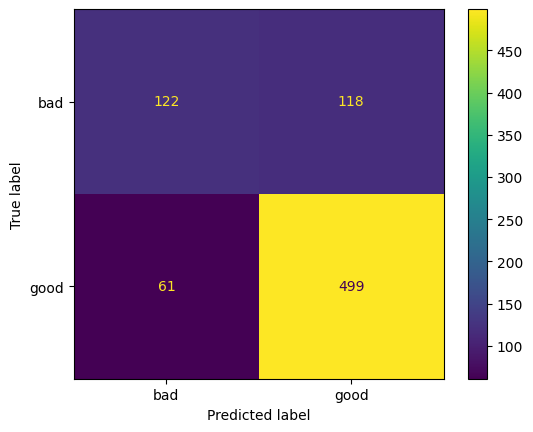

              precision    recall  f1-score   support

         bad       0.67      0.51      0.58       240
        good       0.81      0.89      0.85       560

    accuracy                           0.78       800
   macro avg       0.74      0.70      0.71       800
weighted avg       0.77      0.78      0.77       800


Métricas de avaliação de teste:
[[ 29  31]
 [ 19 121]]


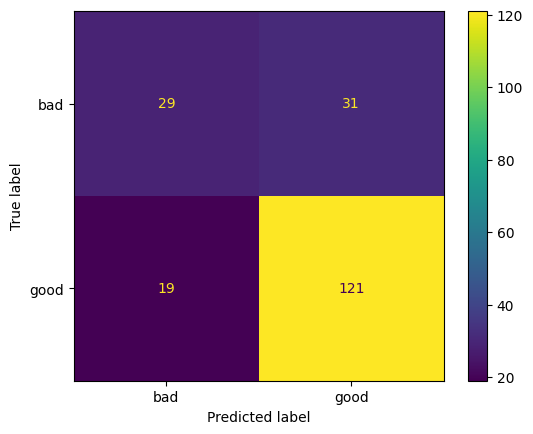

              precision    recall  f1-score   support

         bad       0.60      0.48      0.54        60
        good       0.80      0.86      0.83       140

    accuracy                           0.75       200
   macro avg       0.70      0.67      0.68       200
weighted avg       0.74      0.75      0.74       200



In [19]:
# avalia o modelo
metricas_classificacao(pipe_ab)

Usando n_estimator = 150 - estou chutando um valor. O ideal é fazer um grid/randomsearch

In [20]:
X_train, X_test, y_train, y_test, pre_processador = pipe_pre_process_german()

# pipeline final
pipe_ab = Pipeline([("pre_processador", pre_processador),
                    ("ab", AdaBoostClassifier(random_state=42, n_estimators=150))]) #
# n_estimators=50
# Treinar o modelo
pipe_ab.fit(X_train, y_train)

Pipeline(steps=[('pre_processador',
                 ColumnTransformer(transformers=[('transf_num',
                                                  Pipeline(steps=[('input_num',
                                                                   SimpleImputer()),
                                                                  ('std',
                                                                   StandardScaler())]),
                                                  ['Unnamed: 0', 'Age', 'Job',
                                                   'Credit amount',
                                                   'Duration']),
                                                 ('transf_cat',
                                                  Pipeline(steps=[('input_cat',
                                                                   SimpleImputer(fill_value='unknown',
                                                                                 strategy='constant')),
                                                                  ('onehot',
                                                                   OneHotEncoder())]),
                                                  ['Sex', 'Housing',
                                                   'Saving accounts',
                                                   'Checking account',
                                                   'Purpose'])])),
                ('ab', AdaBoostClassifier(n_estimators=150, random_state=42))])


Métricas de avaliação de treino:
[[143  97]
 [ 51 509]]


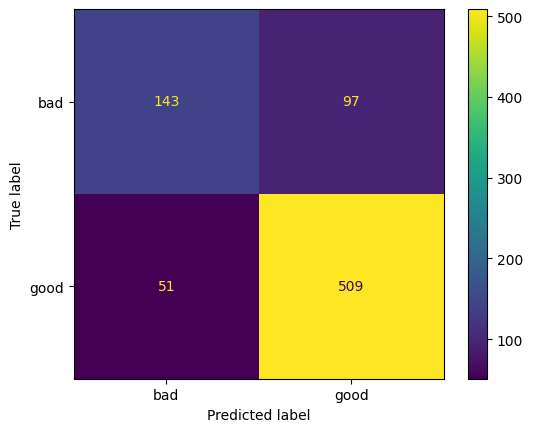

              precision    recall  f1-score   support

         bad       0.74      0.60      0.66       240
        good       0.84      0.91      0.87       560

    accuracy                           0.81       800
   macro avg       0.79      0.75      0.77       800
weighted avg       0.81      0.81      0.81       800


Métricas de avaliação de teste:
[[ 32  28]
 [ 17 123]]


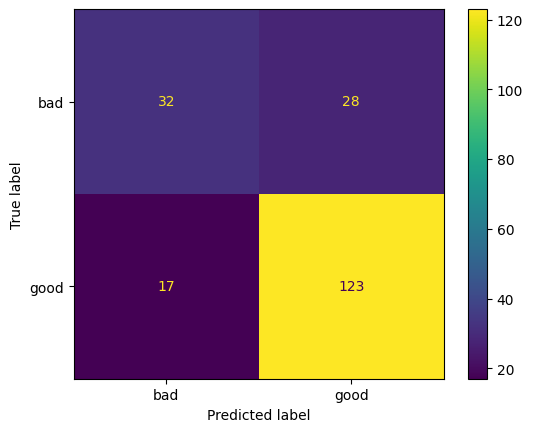

              precision    recall  f1-score   support

         bad       0.65      0.53      0.59        60
        good       0.81      0.88      0.85       140

    accuracy                           0.78       200
   macro avg       0.73      0.71      0.72       200
weighted avg       0.77      0.78      0.77       200



In [21]:
# avalia o modelo
metricas_classificacao(pipe_ab)

In [22]:
# fazer um gridsearch para melhorar os dados
# fazer um adaboost para regressão

In [23]:
from sklearn.model_selection import GridSearchCV

# 'definindo os parametros do grid'
param_grid = {
    'ab__n_estimators': [50, 100, 150],
    'ab__learning_rate': [0.01, 0.1, 1]
}

# criando o modelo
grid_search = GridSearchCV(estimator=pipe_ab, param_grid=param_grid, cv=5, n_jobs=-1, verbose=1)

# treinando
grid_search.fit(X_train, y_train)


Fitting 5 folds for each of 9 candidates, totalling 45 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('pre_processador',
                                        ColumnTransformer(transformers=[('transf_num',
                                                                         Pipeline(steps=[('input_num',
                                                                                          SimpleImputer()),
                                                                                         ('std',
                                                                                          StandardScaler())]),
                                                                         ['Unnamed: '
                                                                          '0',
                                                                          'Age',
                                                                          'Job',
                                                                          'Credit '
                                                                          'amount',
                                                                          'Duration']),
                                                                        ('transf_cat',
                                                                         Pipeline(steps=[('input_cat',
                                                                                          SimpleImputer(fill_value='unknown',
                                                                                                        strategy='constant')),
                                                                                         ('onehot',
                                                                                          OneHotEncoder())]),
                                                                         ['Sex',
                                                                          'Housing',
                                                                          'Saving '
                                                                          'accounts',
                                                                          'Checking '
                                                                          'account',
                                                                          'Purpose'])])),
                                       ('ab',
                                        AdaBoostClassifier(n_estimators=150,
                                                           random_state=42))]),
             n_jobs=-1,
             param_grid={'ab__learning_rate': [0.01, 0.1, 1],
                         'ab__n_estimators': [50, 100, 150]},
             verbose=1)

In [24]:
# outputs das metricas
best_parameters = grid_search.best_params_
best_score = grid_search.best_score_

best_parameters, best_score

({'ab__learning_rate': 0.1, 'ab__n_estimators': 150}, 0.73375)


Métricas de avaliação de treino:
[[ 94 146]
 [ 39 521]]


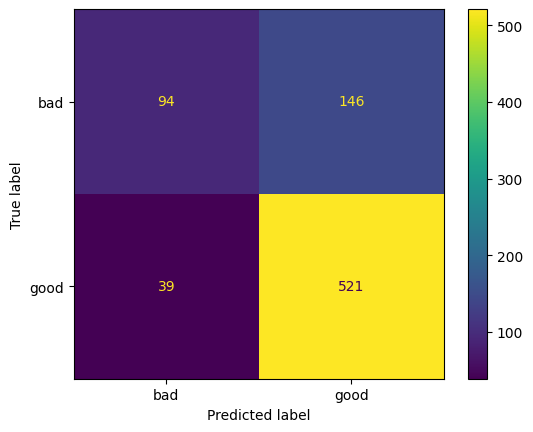

              precision    recall  f1-score   support

         bad       0.71      0.39      0.50       240
        good       0.78      0.93      0.85       560

    accuracy                           0.77       800
   macro avg       0.74      0.66      0.68       800
weighted avg       0.76      0.77      0.75       800


Métricas de avaliação de teste:
[[ 21  39]
 [ 12 128]]


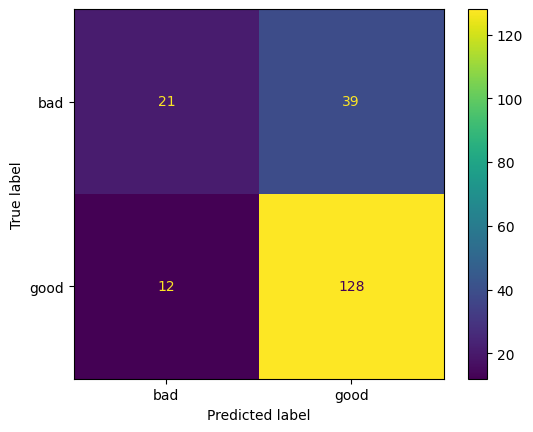

              precision    recall  f1-score   support

         bad       0.64      0.35      0.45        60
        good       0.77      0.91      0.83       140

    accuracy                           0.74       200
   macro avg       0.70      0.63      0.64       200
weighted avg       0.73      0.74      0.72       200



In [25]:
# avalia o modelo
metricas_classificacao(grid_search)

### AdaBoostRegressor

In [27]:
##### Carregar os dados
df = pd.read_csv("/content/german_credit_data.csv")

##### separando as features e target
X = df.drop(columns="Risk")
y = df["Risk"]

##### convertendo valores categóricos em numéricos
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

##### dividindo dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

##### realizando o pipeline
numeric_features = X.select_dtypes(include=['float64', 'int64']).columns
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

##### Pipeline para features categóricas: imputação de valores ausentes e codificação one-hot
categorical_features = X.select_dtypes(include=['object']).columns
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='unknown')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

##### pre-processamento
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

##### Criar pipeline com o pré-processador e o AdaBoostRegressor
pipe_ab_regressor = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', AdaBoostRegressor(random_state=42, n_estimators=150))
])

##### Treinar o modelo
pipe_ab_regressor.fit(X_train, y_train)

##### Avaliar o modelo
y_pred_train = pipe_ab_regressor.predict(X_train)
y_pred_test = pipe_ab_regressor.predict(X_test)

##### Avaliar o modelo (métricas de regressão)
from sklearn.metrics import mean_squared_error, r2_score

print("Mean Squared Error (MSE) - Treino:", mean_squared_error(y_train, y_pred_train))
print("R-squared (R2) - Treino:", r2_score(y_train, y_pred_train))

print("Mean Squared Error (MSE) - Teste:", mean_squared_error(y_test, y_pred_test))
print("R-squared (R2) - Teste:", r2_score(y_test, y_pred_test))


Mean Squared Error (MSE) - Treino: 0.17566472786810283
R-squared (R2) - Treino: 0.1654820341927581
Mean Squared Error (MSE) - Teste: 0.16936286000121512
R-squared (R2) - Teste: 0.1856576030714503
